In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
import scipy

# Linear systems

## Outline

1. LU decomposition as a sum of rank one matrices
2. LU Decomposition with Pivoting
3. Overdetermined Linear Systems (Least Squares)<br>
    3.1 Geometry of Normal Equation <br>
    3.2 Pseudoinverse <br>
    3.3 Pseudoinverse via SVD <br>
    3.4 QR approach <br>
    3.5 Linear Regression

In many applications, we encounter **overdetermined systems** of linear equations, where there are more equations than unknowns, represented as

$$ Ax = b. $$

These systems often lack an exact solution.

To address this, we can use the **least squares method**, which finds an approximate solution by minimizing the residual error:

$$ x = \arg\min_x \| Ax - b \|_2 $$

## Overdetermined Linear Systems

Many applications lead to unsolvable linear equations $Ax = b$, where the number of equations is greater, than the number of unknowns.

The least squares method chooses the solution as

$$ x = \arg\min_x \| Ax - b \|_2$$

### The Normal Equation

The solution to the least squares problem satisfies the **normal equation**:

$$ A^T A x = A^T b $$

When $ A $ has full column rank, the matrix $ A^T A $ is **positive definite**, allowing us to solve this equation efficiently with **Cholesky decomposition**:

$$ A^T A = R^T R $$

where $ R $ is an upper triangular matrix (and $ R^T $ is lower triangular). This leads to the following set of equations:

$$
\begin{align}
    R^T y &= A^T b \\
    R x &= y
\end{align}
$$

However, solving the normal equations directly can be numerically unstable, especially for larger problems. This approach is generally safe for small problems, but for stability, other methods are recommended. If the pivots in Gaussian elimination are small, **LU decomposition** may fail, whereas **Cholesky decomposition** remains stable in these cases.

In [2]:
# Cholesky Decomposition Method
def leastsq_chol(A, b):
    R = scipy.linalg.cholesky(A.T @ A)
    w = scipy.linalg.solve_triangular(R, A.T @ b, trans='T')
    return scipy.linalg.solve_triangular(R, w)

### The Pseudoinverse

In linear algebra, not all matrices have an inverse, particularly when a system of equations has no solution or many solutions. The **Moore-Penrose pseudoinverse** offers a way to find an approximate solution that minimizes error, even when a unique solution doesn’t exist.

In the lecture, the pseudoinverse is defined as:

$$ A^{\dagger} = \lim_{\alpha \to 0} (A^T A + \alpha I)^{-1} A^T $$

Alternatively,

$$ A^{\dagger} = \lim_{\alpha \to 0} A^T (A A^T + \alpha I)^{-1} $$

These limits exist even if $ (A^T A)^{-1} $ or $ (A A^T)^{-1} $ do not. Later, we will see how this relates to **Tikhonov regularization**.

If $ A $ has full column rank, the pseudoinverse simplifies to:

$$ A^{\dagger} = (A^T A)^{-1} A^T $$


### Computing the Pseudoinverse Using SVD

Another way to compute the pseudoinverse is through the **Singular Value Decomposition (SVD)** $ A = U \Sigma V^T $:

$$ A^{\dagger} = V \Sigma^{\dagger} U^T $$

In this approach, we invert the diagonal entries of $ \Sigma $ where possible.

With the pseudoinverse $ A^{\dagger} $, we can write the solution to $ Ax = b $ as:

$$ x = A^{\dagger} b $$

### Example: Solving a System Using Pseudoinverse

Let’s now consider the toy matrix and system of equations:

$$ \begin{bmatrix} 1 & -1 \\ 2 & 1 \\ -1 & 3 \end{bmatrix} x = \begin{bmatrix} 0 \\ 3 \\ 2 \end{bmatrix} $$

In [3]:
# Pseudo-inverse Method using Matrix Inversion
def leastsq_pinv(A, b):
    return np.linalg.inv(A.T @ A) @ A.T @ b

In [4]:
# Pseudo-inverse Method using SVD
def leastsq_pinv_svd(A, b):
    U, S, Vh = scipy.linalg.svd(A)
    S_plus = np.zeros(A.shape).T
    S_plus[:S.shape[0], :S.shape[0]] = np.linalg.inv(np.diag(S))
    return Vh.T @ S_plus @ U.T @ b

Let's now return to our toy matrix and consider the system

$$\begin{bmatrix} 1 & -1 \\ 2 & 1 \\ -1 & 3 \end{bmatrix} x =\begin{bmatrix} 0 \\ 3 \\ 2 \end{bmatrix} $$

In [5]:
A = np.array([[1., -1.], [2., 1.], [-1., 3.]])
b = np.array([[0.], [3.], [2.]])

In [6]:
print("Condition number of A:\n", np.linalg.cond(A))

Condition number of A:
 1.486099875177604


In [7]:
A_pinv = np.linalg.pinv(A)
x_sol = A_pinv @ b
print("\n Solution by using pseudoinverse: \n", x_sol)


 Solution by using pseudoinverse: 
 [[1.]
 [1.]]


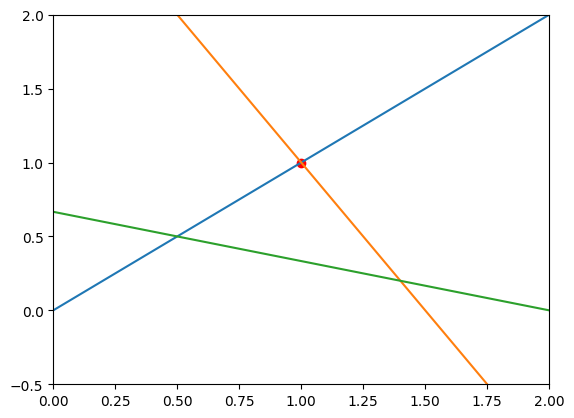

In [8]:
x_1 = np.linspace(-3, 3, 100)
x_2_1 = x_1
x_2_2 = 3. - 2. * x_1
x_2_3 =(2. - x_1) / 3

plt.plot(x_1, x_2_1)
plt.plot(x_1, x_2_2)
plt.plot(x_1, x_2_3)
plt.scatter(x_sol[0], x_sol[1], c='r')

plt.xlim(0., 2.)
plt.ylim(-0.5, 2.)
plt.show()

### QR Decomposition for Solving Least Squares Problem

If $ A $ has full column rank, a **QR decomposition** exists for $ A $:

$$ A = QR $$

This allows us to rewrite the normal equations as:

$$ R^T Q^T Q R x = R^T Q^T b $$

Since $ Q^T Q = I $, this further simplifies to:

$$ R x = Q^T b. $$

In [9]:
# QR Decomposition Method
def leastsq_qr(A, b):
    Q, R = scipy.linalg.qr(A, mode='economic')
    return scipy.linalg.solve_triangular(R, Q.T @ b)

### Linear Regression

In [10]:
def SyntheticData(x, corr_col=False, noise=0.1, num_points=100):
    A = np.random.randn(num_points, len(x) - 1)
    A = np.hstack((A, np.ones((num_points, 1))))
    if corr_col and len(x) > 2:
        A[:, 2] = A[:, 1] + np.random.rand(num_points) * noise * 1e-4
    noise = np.random.randn(num_points, 1) * noise
    b = A @ x.reshape((-1, 1)) + noise
    return A, b

Condition number of A:
 1.0244254246033382
True coefficients:
 [2. 1.]
Cholesky solution:
 [2.00447795 0.99995264]
Pseudo-inverse solution:
 [2.00447795 0.99995264]
SVD solution:
 [2.00447795 0.99995264]
QR solution:
 [2.00447795 0.99995264]


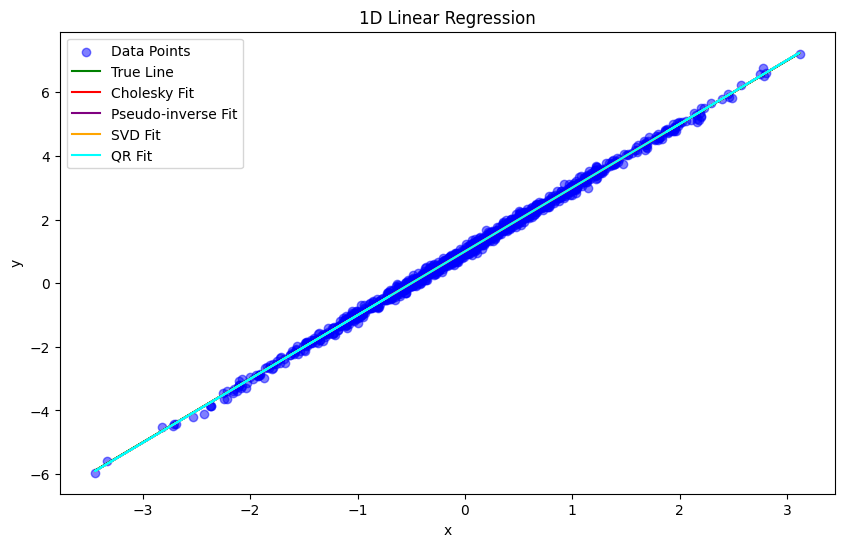

In [11]:
x_true = np.array([2.0, 1.0])

A, b = SyntheticData(x_true, num_points=1000)

x_chol = leastsq_chol(A, b)
x_pinv = leastsq_pinv(A, b)
x_svd = leastsq_pinv_svd(A, b)
x_qr = leastsq_qr(A, b)

print("Condition number of A:\n", np.linalg.cond(A))

print("True coefficients:\n", x_true)
print("Cholesky solution:\n", x_chol.flatten())
print("Pseudo-inverse solution:\n", x_pinv.flatten())
print("SVD solution:\n", x_svd.flatten())
print("QR solution:\n", x_qr.flatten())

plt.figure(figsize=(10, 6))
plt.scatter(A[:, 0], b, label='Data Points', color='blue', alpha=0.5)

plt.plot(A[:, 0], A @ x_true, label='True Line', color='green')
plt.plot(A[:, 0], A @ x_chol, label='Cholesky Fit', color='red')
plt.plot(A[:, 0], A @ x_pinv, label='Pseudo-inverse Fit', color='purple')
plt.plot(A[:, 0], A @ x_svd, label='SVD Fit', color='orange')
plt.plot(A[:, 0], A @ x_qr, label='QR Fit', color='cyan')

plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title('1D Linear Regression')
plt.show()

Finally, let’s consider the case where $ A $ does not have full column rank.

In [12]:
x_true = np.array([2.0, 3.0, -1.0, 1.0])

A, b = SyntheticData(x_true, corr_col=True, num_points=1000)

x_chol = leastsq_chol(A, b)
x_pinv = leastsq_pinv(A, b)
x_svd = leastsq_pinv_svd(A, b)
x_qr = leastsq_qr(A, b)

print("Condition number of A:\n", np.linalg.cond(A))

print("True coefficients:\n", x_true)
print("Cholesky solution:\n", x_chol.flatten())
print("Pseudo-inverse solution:\n", x_pinv.flatten())
print("SVD solution:\n", x_svd.flatten())
print("QR solution:\n", x_qr.flatten())

Condition number of A:
 701358.942031971
True coefficients:
 [ 2.  3. -1.  1.]
Cholesky solution:
 [   2.0023748   673.23409979 -671.22909701    1.01128535]
Pseudo-inverse solution:
 [   2.00237495  673.23379791 -671.22879157    1.01128535]
SVD solution:
 [   2.00237481  673.21088747 -671.20588469    1.01128523]
QR solution:
 [   2.00237481  673.21088747 -671.20588468    1.01128523]


 In such cases Tikhonov regularization is more effective for finding stable solutions.

**<u>Exercise</u>** Show that the problem

$$ \min \|x'\|_2 \quad \text{s.t. } x' = \arg\min_x \| Ax - b \|_2^2 $$

is equivalent to the following regularization problem:

$$ \min_x \| Ax - b \|_2^2 + \lambda \|x\|_2^2. $$

Note that the analytical solution is available in this case as well:

$$ x^* = (A^T A + \lambda I)^{-1}  X^T b.$$

The analytical solutions described earlier involve inverting the matrix $A^T A$ (or $A^T A + \lambda I$), which is computationally expensive. This brings us to iterative methods, which are generally more efficient and have become the primary approach for numerous applications.

**Gradient descent** is one of the most widely used optimization methods. It is important to note that the objective function (e.g., the loss function, which is the residual in our case: $\mathcal{L}(x) = \|Ax - b\|_2^2$) should be differentiable with respect to the unknown $ x $. Using gradient descent, the weight vector at each step can be updated as follows:

$$ x^{k+1} = x^k - \beta_k \nabla \mathcal{L}(x^k) $$

**<u>Exercise</u>** Compute the gradient of $$\mathcal{L}_{\lambda}(x) = \|Ax - b\|_2^2 + \lambda \|x\|_2^2.$$

To further improve efficiency, one could use **stochastic gradient descent (SGD)**, which computes the gradient over a randomly selected subset of data points, rather than the full dataset $A$.

These ideas will be explored further in the second homework assignment... stay tuned!